# VTK - ITK Project : Etude longitudinale de l'évolution d'une tumeur

### Par Raphaël Duhen, Maël Conan et Nigel Andrews

In [21]:
# Imports
import vtk
import itk
import matplotlib.pyplot as plt
import numpy as np

In [22]:
def run_window(path: str):
    reader = vtk.vtkNrrdReader()
    reader.SetFileName(path)
    
    window = vtk.vtkRenderWindow()
    renderer = vtk.vtkRenderer()
    
    window.AddRenderer(renderer)
    
    interactor = vtk.vtkRenderWindowInteractor()
    window.SetInteractor(interactor)
    
    contour = vtk.vtkContourFilter()
    contour.SetInputConnection(reader.GetOutputPort())
    contour.SetValue(0, 135)
    contour.SetFastOff()
    
    contourMapper = vtk.vtkPolyDataMapper()
    contourMapper.SetInputConnection(contour.GetOutputPort())
    contourMapper.ScalarVisibilityOff()
    
    contourActor = vtk.vtkActor()
    contourActor.SetMapper(contourMapper)
    
    renderer.AddActor(contourActor)
    
    window.Render()
    interactor.Start()

In [23]:
# Define types
PixelType = itk.D
Dimension = 3
ImageType = itk.Image[PixelType, Dimension]
TransformType = itk.TranslationTransform[PixelType, Dimension]

In [24]:
# Load images
image = itk.imread("Data/case6_gre1.nrrd", pixel_type=PixelType)
image2 = itk.imread("Data/case6_gre2.nrrd", pixel_type=PixelType) 

In [26]:
def registration(image, image2):
    # Définir le type de transformation
    dimension = image.GetImageDimension()
    TransformType = itk.TranslationTransform[itk.D, dimension]

    # Initialiser la transformation
    initial_transform = TransformType.New()
    initial_transform.SetIdentity()

    # Définir les paramètres de l'optimiseur
    optimizer = itk.RegularStepGradientDescentOptimizerv4.New(
        LearningRate=4,
        MinimumStepLength=0.001,
        RelaxationFactor=0.5,
        NumberOfIterations=200,
    )

    # Définir les paramètres de la métrique
    metric = itk.MeanSquaresImageToImageMetricv4[ImageType, ImageType].New()

    # Définir les paramètres de l'interpolateur
    # interpolator = itk.LinearInterpolateImageFunction[ImageType, itk.D].New()

    # Définir les paramètres de la méthode de recalage
    registration = itk.ImageRegistrationMethodv4[ImageType, ImageType].New(
        Metric=metric,
        Optimizer=optimizer,
        InitialTransform=initial_transform,
        FixedImage=image,
        MovingImage=image2,
    )

    # Lancer le recalage
    registration.Update()

    return registration, optimizer

In [27]:
def transform_image(image, image2, registration):
    # Transform image
    transformed_image = itk.resample_image_filter(
        image2,
        transform=registration.GetTransform(),
        use_reference_image=True,
        reference_image=image,
        default_pixel_value=100,
    )

    return transformed_image

In [28]:
registration, optimizer = registration(image, image2)


In [38]:
try:
    transformed_image = itk.imread("Data/transformed_image.nrrd", pixel_type=PixelType)
except:
    transformed_image = transform_image(image, image2, registration)

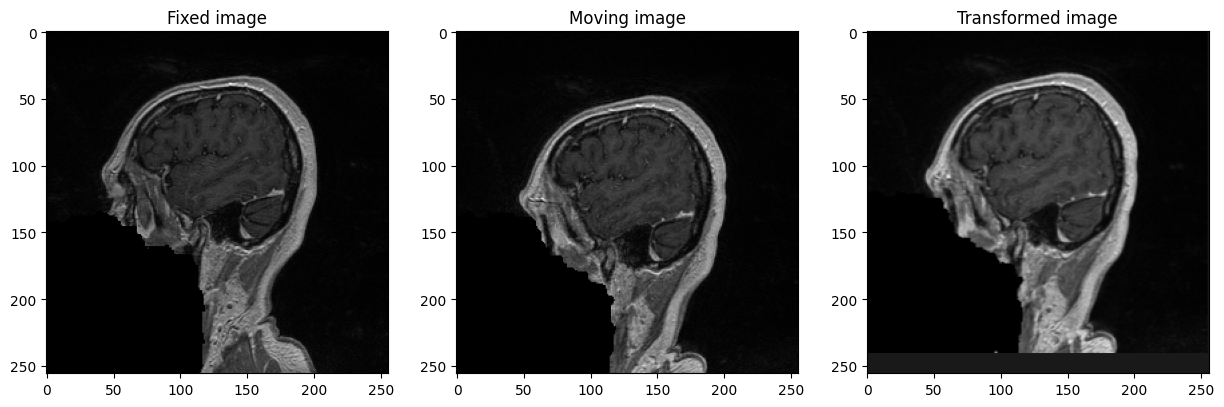

In [36]:
array_view = itk.array_view_from_image(transformed_image)
original_fixed_view = itk.array_view_from_image(image)
original_moving_view = itk.array_view_from_image(image2)

# Plot images
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(original_fixed_view[135, :, :], cmap="gray")
plt.title("Fixed image")
plt.subplot(1, 3, 2)
plt.imshow(original_moving_view[135, :, :], cmap="gray")
plt.title("Moving image")
plt.subplot(1, 3, 3)
plt.imshow(array_view[135, :, :], cmap="gray")
plt.title("Transformed image")
plt.show()

In [31]:
# Save image
itk.imwrite(transformed_image, "Data/transformed_image.nrrd")

In [37]:
# Get final parameters
final_parameters = registration.GetOutput().Get().GetParameters()

# # Get final metric value
# final_metric_value = registration.GetMetricValue()

# Get final number of iterations
final_number_of_iterations = optimizer.GetCurrentIteration()

# Print final parameters in detail
print("Final parameters = ", final_parameters.GetElement(0))
print("Final parameters = ", final_parameters.GetElement(1))
print("Final parameters = ", final_parameters.GetElement(2))
print("Final parameters = ", final_parameters.GetElement(3))
print("Final parameters = ", final_parameters.GetElement(4))
print("Final parameters = ", final_parameters.GetElement(5))

# print("Metric value = ", final_metric_value)
print("Number of iterations = ", final_number_of_iterations)

Final parameters =  -0.8339130025804753
Final parameters =  -3.54112087911544
Final parameters =  -59.455066840126456
Final parameters =  3.88e-321
Final parameters =  1.5e-323
Final parameters =  6.94223094131595e-310
Number of iterations =  20


In [ ]:
# Segment tumour from transformed image
def segment_tumour(transformed_image):
    # Get array view from image
    array_view = itk.array_view_from_image(transformed_image)

    # Get tumour
    tumour = np.where(array_view > 150, 1, 0)

    # Get tumour image
    tumour_image = itk.image_from_array(tumour)

    return tumour_image